In [1]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
import hvplot.pandas

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn import datasets
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn import svm
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, recall_score 
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, precision_score, f1_score,
    precision_recall_curve, average_precision_score,
    roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay
   )

import xgboost as xgb
from xgboost import XGBClassifier

import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization 
from keras.optimizers import Adam
from keras.metrics import AUC

import warnings

import holoviews as hv

from datetime import datetime

from xgboost import XGBRFClassifier

import os

import pickle

import emoji

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 10)

In [2]:
df=pd.read_csv('D:/PERSONAL-DAS/BOOTCAMP/Carpeta-VISUAL/CURSO/Alumno-DAS/3-Machine_Learning/Entregas/ML_project/Preddicion Prestamos Fallidos/data/lending-club-loan_ML_stand1_balnc.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153882 entries, 0 to 153881
Data columns (total 66 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   C-1          153882 non-null  float64
 1   C-2          153882 non-null  float64
 2   C-3          153882 non-null  float64
 3   C-4          153882 non-null  float64
 4   C-5          153882 non-null  float64
 5   C-6          153882 non-null  float64
 6   C-7          153882 non-null  float64
 7   C-8          153882 non-null  float64
 8   C-9          153882 non-null  float64
 9   C-10         153882 non-null  float64
 10  C-11         153882 non-null  float64
 11  C-12         153882 non-null  float64
 12  C-13         153882 non-null  float64
 13  C-14         153882 non-null  float64
 14  C-15         153882 non-null  float64
 15  C-16         153882 non-null  float64
 16  C-17         153882 non-null  float64
 17  C-18         153882 non-null  float64
 18  C-19         153882 non-

# models building 

In [4]:
def save_score(true, pred, model_name, train=True, auc_roc=None):
    timestamp = datetime.now().strftime('%Y%m')
    file_name = f"{model_name}_TestResults_{timestamp}.csv"

    clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
    accuracy = accuracy_score(true, pred) * 100
    roc_auc = roc_auc_score(true, pred) * 100
    confusion = confusion_matrix(true, pred)

    if auc_roc is not None:
        result_df = pd.DataFrame({
            'Set': ['Train' if train else 'Test'],
            'Accuracy': [accuracy],
            'AUC-ROC': [roc_auc],
            'Classification Report': [clf_report.to_dict()],
            'Confusion Matrix': [confusion.tolist()]
        })
    else:
        result_df = pd.DataFrame({
            'Set': ['Train' if train else 'Test'],
            'Accuracy': [accuracy],
            'AUC-ROC': [roc_auc],
            'Classification Report': [clf_report.to_dict()],
            'Confusion Matrix': [confusion.tolist()]
        })

    current_dir = os.getcwd()
    pruebas_dir = os.path.join(current_dir, 'Pruebas')
    os.makedirs(pruebas_dir, exist_ok=True)

    # Unir la ruta del directorio 'pruebas' con el nombre del archivo CSV
    file_path = os.path.join(pruebas_dir, file_name)

    result_df.to_csv(file_path, index=False)
    

In [5]:
def print_score(true, pred, model_name, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
    else:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")


In [6]:
def plot_confusion_matrix(model, X_test, y_test, model_name):
    # Predicciones del modelo
    preds = model.predict(X_test)

    # Matriz de confusión
    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.ravel()
    
    # Configurar el gráfico
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Pred Neg', 'Pred Pos'], yticklabels=['True Neg', 'True Pos'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    # Calcular porcentajes
    total = tn + fp + fn + tp
    accuracy = (tp + tn) / total * 100
    error_rate = (fp + fn) / total * 100
    precision = tp / (tp + fp) * 100 if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) * 100 if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    # Calcular total de positivos y negativos con sus porcentajes
    total_correct = tp + tn
    total_errors = fp + fn
    percent_correct = total_correct / total * 100
    percent_errors = total_errors / total * 100

    # Mostrar resultados
    print(f"\nTotal Correct: {total_correct} ({percent_correct:.2f}%)")
    print('--'*30)
    print(f"True Positives (TP): {tp} ({tp/total*100:.2f}%)")
    print(f"True Negatives (TN): {tn} ({tn/total*100:.2f}%)")

    print(f"\nTotal Errors: {total_errors} ({percent_errors:.2f}%)")
    print('--'*30)
    print(f"False Positives (FP): {fp} ({fp/total*100:.2f}%)")
    print(f"False Negatives (FN): {fn} ({fn/total*100:.2f}%)")

In [7]:
def plot_roc_pr_curves(model, X_test, y_test, model_name):
    # Curva ROC
    y_test_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
    roc_auc = roc_auc_score(y_test, y_test_probs)

    # Curva P-R
    precision, recall, _ = precision_recall_curve(y_test, y_test_probs)

    # Crear la figura con dos subgráficos
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Graficar Curva ROC
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('Tasa de Falsos Positivos')
    ax1.set_ylabel('Tasa de Verdaderos Positivos')
    ax1.set_title(f'Curva ROC - {model_name}')
    ax1.legend(loc='lower right')

    # Graficar Curva P-R
    ax2.plot(recall, precision, color='darkorange', lw=2, label='P-R curve')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# modelos

## LR

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Supongamos que ya tienes tu conjunto de datos df

# Definir la variable objetivo y las características
target = 'loan_status'
X = df.drop(columns=[target])
y = df[target]

# División de datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarización de las características (opcional, pero a menudo recomendado para modelos lineales)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Creación del modelo - Regresión Logística con parámetros predeterminados 
logreg_model = LogisticRegression(random_state=42, max_iter=1000)  
logreg_model.fit(X_train_std, y_train)

# Predicciones en el conjunto de prueba
y_pred = logreg_model.predict(X_test_std)

# Evaluación del modelo con parámetros predeterminados
accuracy_default = accuracy_score(y_test, y_pred)
print(f'Accuracy con parámetros predeterminados: {accuracy_default}')


Accuracy con parámetros predeterminados: 0.7712252656204308


In [9]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Definir la distribución de los hiperparámetros a explorar
param_dist = {
    'C': np.logspace(-3, 3, 7),  # Distribución logarítmica para el parámetro de regularización C
}

# Crear el modelo de Regresión Logística
logreg_model = LogisticRegression(random_state=42, max_iter=1000)

# Inicializar RandomizedSearchCV
random_search = RandomizedSearchCV(logreg_model, param_distributions=param_dist, n_iter=7, cv=5, scoring='accuracy', random_state=42)

# Realizar la búsqueda aleatoria en los datos de entrenamiento estandarizados
random_search.fit(X_train_std, y_train)

# Obtener los mejores parámetros y evaluar el modelo
best_params_random = random_search.best_params_
print(f'Mejores parámetros encontrados (búsqueda aleatoria): {best_params_random}')

# Predicciones en el conjunto de prueba con los mejores parámetros
y_pred_random = random_search.predict(X_test_std)

# Evaluación del modelo con los mejores parámetros
accuracy_random = accuracy_score(y_test, y_pred_random)
print(f'Accuracy con mejores parámetros (búsqueda aleatoria): {accuracy_random}')

Mejores parámetros encontrados (búsqueda aleatoria): {'C': 1.0}
Accuracy con mejores parámetros (búsqueda aleatoria): 0.7712252656204308


In [10]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Después de obtener el mejor modelo de la búsqueda aleatoria
best_model = random_search.best_estimator_

# Predicciones en los conjuntos de entrenamiento y prueba con los mejores parámetros
train_preds = best_model.predict(X_train_std)
test_preds = best_model.predict(X_test_std)

model_name = 'LogisticRegression'

# Llamada a la función para imprimir métricas
print_score(y_train, train_preds, model_name, train=True)
print_score(y_test, test_preds, model_name, train=False)

Train Result:
Accuracy Score: 77.20%
_______________________________________________
CLASSIFICATION REPORT:
                 0        1  accuracy  macro avg  weighted avg
precision     0.77     0.77      0.77       0.77          0.77
recall        0.77     0.77      0.77       0.77          0.77
f1-score      0.77     0.77      0.77       0.77          0.77
support   61712.00 61393.00      0.77  123105.00     123105.00
_______________________________________________
Confusion Matrix: 
 [[47598 14114]
 [13951 47442]]

Test Result:
Accuracy Score: 77.12%
_______________________________________________
CLASSIFICATION REPORT:
                 0        1  accuracy  macro avg  weighted avg
precision     0.77     0.77      0.77       0.77          0.77
recall        0.77     0.77      0.77       0.77          0.77
f1-score      0.77     0.77      0.77       0.77          0.77
support   15229.00 15548.00      0.77   30777.00      30777.00
_______________________________________________
Confusi

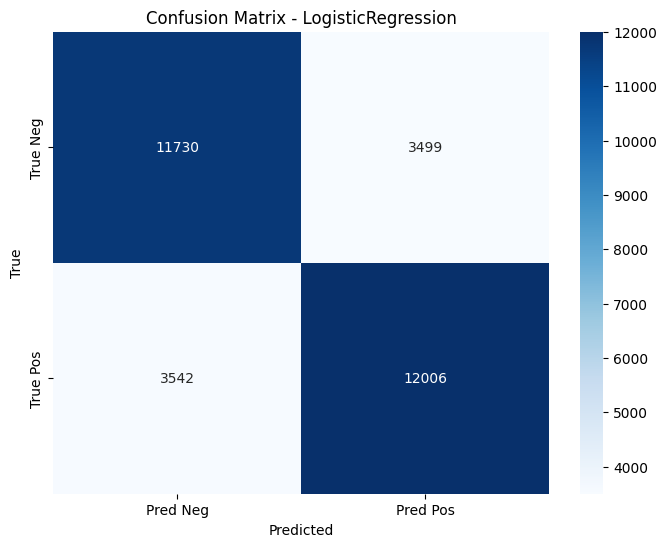


Total Correct: 23736 (77.12%)
------------------------------------------------------------
True Positives (TP): 12006 (39.01%)
True Negatives (TN): 11730 (38.11%)

Total Errors: 7041 (22.88%)
------------------------------------------------------------
False Positives (FP): 3499 (11.37%)
False Negatives (FN): 3542 (11.51%)


In [11]:
# Llamada a la función para graficar la matriz de confusión
plot_confusion_matrix(best_model, X_test_std, y_test, model_name)


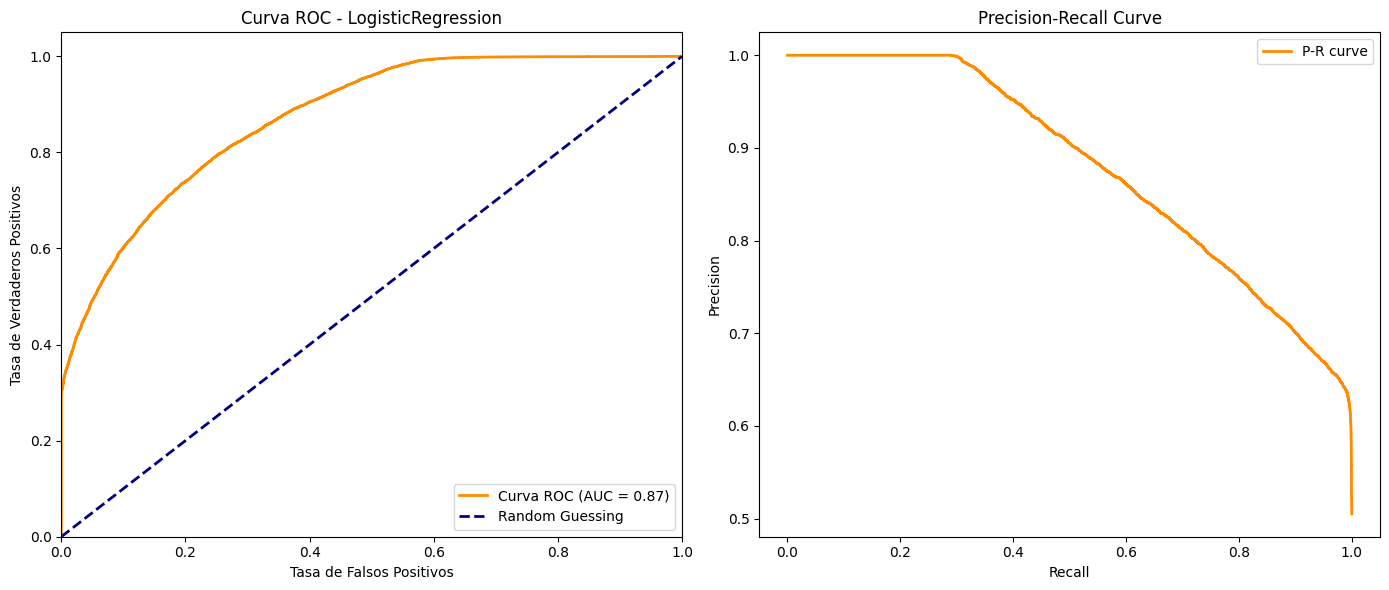

In [12]:
# Llamada a la función para graficar las curvas ROC y P-R
plot_roc_pr_curves(best_model, X_test_std, y_test, model_name)

In [13]:

# Llamada a la función para guardar los resultados en un archivo CSV
save_score(y_train, train_preds, model_name, train=True)
save_score(y_test, test_preds, model_name, train=False)


## RF

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score
import numpy as np

# Modelo con parámetros predeterminados
model_name = 'RandomForest'
rand_forest_default = RandomForestClassifier(random_state=42)

# División de datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento del modelo predeterminado
rand_forest_default.fit(X_train, y_train)

# Evaluación en el conjunto de prueba
preds_default = rand_forest_default.predict(X_test)
accuracy_default = accuracy_score(y_test, preds_default)
recall_default = recall_score(y_test, preds_default)

print(f'Precisión en el conjunto de prueba (predeterminado): {accuracy_default:.4f}')
print(f'Recall en el conjunto de prueba (predeterminado): {recall_default:.4f}')


Precisión en el conjunto de prueba (predeterminado): 0.7828
Recall en el conjunto de prueba (predeterminado): 0.7842


In [15]:
# Definición de hiperparámetros (distribución logarítmica para RandomizedSearchCV)
param_dist = {
    'n_estimators': [int(x) for x in np.logspace(1, 3, num=20)],
    'max_features': [1, 2, 3]
}

# Búsqueda aleatoria de hiperparámetros
rand_forest_random = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist,
                                         n_iter=10, cv=10, scoring='accuracy', random_state=42, n_jobs=-1)

# Entrenamiento del modelo con búsqueda aleatoria
rand_forest_random.fit(X_train, y_train)

# Resultados de la búsqueda aleatoria
print(f'\nMejores parámetros (búsqueda aleatoria): {rand_forest_random.best_params_}')
print(f'Precisión en el conjunto de entrenamiento (búsqueda aleatoria): {rand_forest_random.best_score_:.4f}')

# Evaluación en el conjunto de prueba con los mejores parámetros
preds_random = rand_forest_random.best_estimator_.predict(X_test)
accuracy_random = accuracy_score(y_test, preds_random)
recall_random = recall_score(y_test, preds_random)

print(f'Precisión en el conjunto de prueba (búsqueda aleatoria): {accuracy_random:.4f}')
print(f'Recall en el conjunto de prueba (búsqueda aleatoria): {recall_random:.4f}')


Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                 0        1  accuracy  macro avg  weighted avg
precision     1.00     1.00      1.00       1.00          1.00
recall        1.00     1.00      1.00       1.00          1.00
f1-score      1.00     1.00      1.00       1.00          1.00
support   61712.00 61393.00      1.00  123105.00     123105.00
_______________________________________________
Confusion Matrix: 
 [[61712     0]
 [    0 61393]]

Test Result:
Accuracy Score: 77.89%
_______________________________________________
CLASSIFICATION REPORT:
                 0        1  accuracy  macro avg  weighted avg
precision     0.78     0.78      0.78       0.78          0.78
recall        0.77     0.78      0.78       0.78          0.78
f1-score      0.78     0.78      0.78       0.78          0.78
support   15229.00 15548.00      0.78   30777.00      30777.00
_______________________________________________
Confus

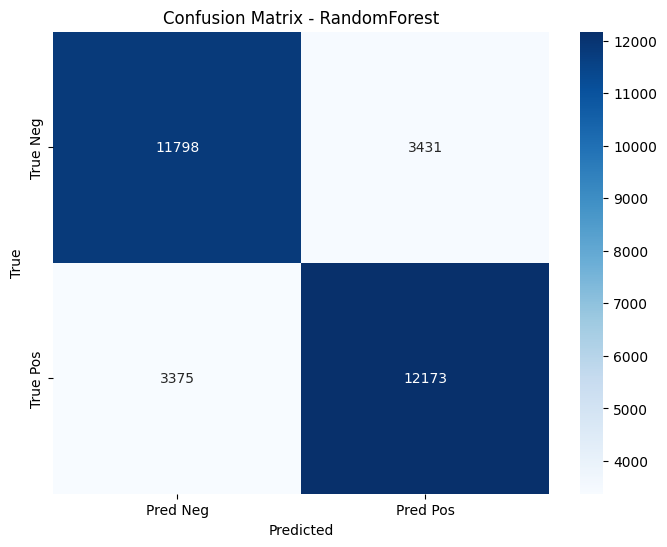


Total Correct: 23971 (77.89%)
------------------------------------------------------------
True Positives (TP): 12173 (39.55%)
True Negatives (TN): 11798 (38.33%)

Total Errors: 6806 (22.11%)
------------------------------------------------------------
False Positives (FP): 3431 (11.15%)
False Negatives (FN): 3375 (10.97%)


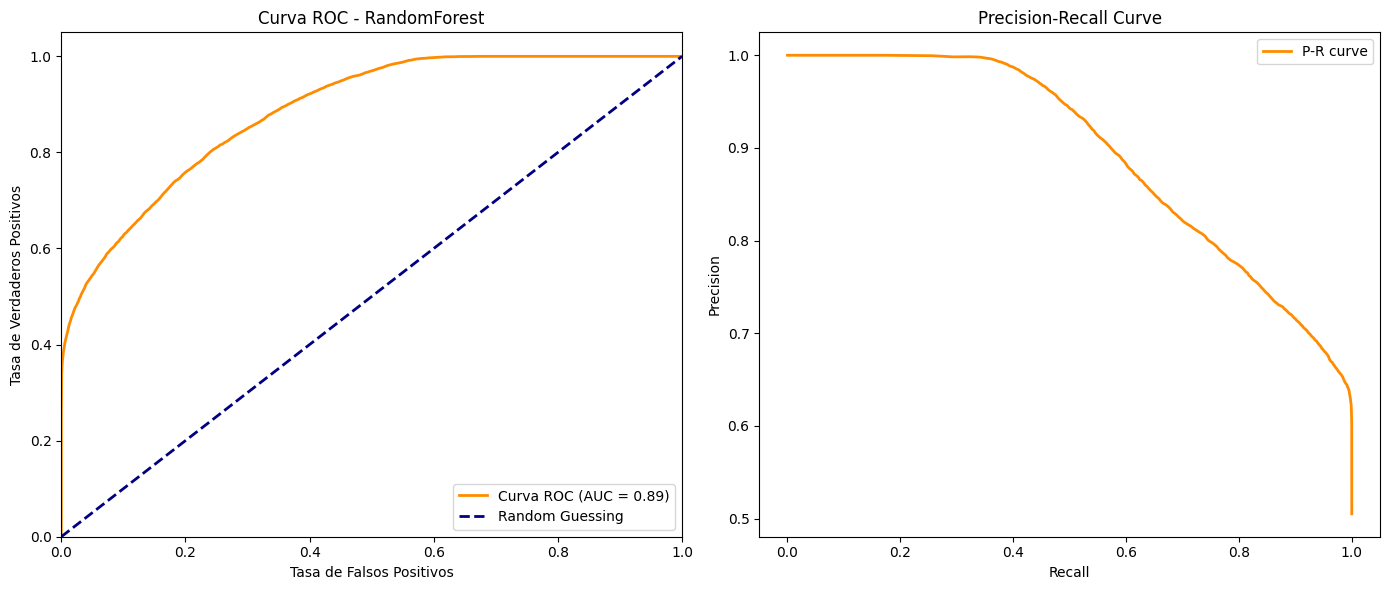

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Después de obtener el mejor modelo de la búsqueda aleatoria
best_model = rand_forest_random.best_estimator_

# Predicciones en los conjuntos de entrenamiento y prueba con los mejores parámetros
train_preds = best_model.predict(X_train)
test_preds = best_model.predict(X_test)

model_name_rf = 'RandomForest'
# Llamada a las funciones después de entrenar el modelo
print_score(y_train, train_preds, model_name, train=True)
print_score(y_test, test_preds, model_name, train=False)
# Plot Confusion Matrix
plot_confusion_matrix(best_model, X_test, y_test, model_name)
# Plot Curvas ROC y P-R
plot_roc_pr_curves(best_model, X_test, y_test, model_name)

In [ ]:

# Guardar resultados en archivo CSV
save_score(y_train, train_preds, model_name, train=True)
save_score(y_test, test_preds, model_name, train=False)


## XG

In [ ]:
from xgboost import XGBRFClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
from sklearn.preprocessing import StandardScaler

# Suponiendo que df es tu DataFrame y 'loan_status' es tu columna objetivo
target = 'loan_status'
X = df.drop(columns=[target])
y = df[target]

# División de datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Configuración del modelo XGBoost
xgboost_model = XGBRFClassifier(random_state=42)

# Entrenamiento del modelo con datos de entrenamiento
xgboost_model.fit(X_train, y_train)

# Predicciones en conjunto de prueba
preds_xgboost = xgboost_model.predict(X_test)

# Evaluación del modelo en el conjunto de prueba
accuracy_xgboost = accuracy_score(y_test, preds_xgboost)
recall_xgboost = recall_score(y_test, preds_xgboost)

print(f'Precisión en el conjunto de prueba (modelo inicial): {accuracy_xgboost:.4f}')
print(f'Recall en el conjunto de prueba (modelo inicial): {recall_xgboost:.4f}')


Precisión en el conjunto de prueba (modelo inicial): 0.7692
Recall en el conjunto de prueba (modelo inicial): 0.7975


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Definición de hiperparámetros (distribución logarítmica para RandomizedSearchCV)
xgboost_params = {
    'n_estimators': [int(x) for x in np.logspace(1, 3, num=20)],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5],
    'max_depth': [2, 3, 4, 5],
    'subsample': [0.8, 1.0],
}

# Búsqueda aleatoria de hiperparámetros
random_search_xgboost = RandomizedSearchCV(xgboost_model, xgboost_params, n_iter=10, cv=10, scoring='accuracy', random_state=42, n_jobs=-1)

# Entrenamiento del modelo con búsqueda aleatoria
random_search_xgboost.fit(X_train, y_train)

# Resultados de la búsqueda aleatoria
print(f'\nMejores parámetros (búsqueda aleatoria): {random_search_xgboost.best_params_}')
print(f'Precisión en el conjunto de entrenamiento (búsqueda aleatoria): {random_search_xgboost.best_score_:.4f}')

# Evaluación en el conjunto de prueba con los mejores parámetros
preds_best_xgboost = random_search_xgboost.best_estimator_.predict(X_test)
accuracy_best_xgboost = accuracy_score(y_test, preds_best_xgboost)
recall_best_xgboost = recall_score(y_test, preds_best_xgboost)

print(f'Precisión en el conjunto de prueba (mejores parámetros): {accuracy_best_xgboost:.4f}')
print(f'Recall en el conjunto de prueba (mejores parámetros): {recall_best_xgboost:.4f}')



Mejores parámetros (búsqueda aleatoria): {'subsample': 0.8, 'n_estimators': 69, 'max_depth': 5, 'learning_rate': 0.2}
Precisión en el conjunto de entrenamiento (búsqueda aleatoria): 0.7594
Precisión en el conjunto de prueba (mejores parámetros): 0.7603
Recall en el conjunto de prueba (mejores parámetros): 0.7701


In [ ]:
# Llamada a las funciones después de entrenar el modelo
train_preds_best_xgboost = random_search_xgboost.best_estimator_.predict(X_train)
test_preds_best_xgboost = random_search_xgboost.best_estimator_.predict(X_test)

model_name_best_xgboost = 'XGBRFClassifier'
# Llamada a las funciones después de entrenar el modelo
print_score(y_train, train_preds_best_xgboost, model_name_best_xgboost, train=True)
print_score(y_test, test_preds_best_xgboost, model_name_best_xgboost, train=False)


Train Result:
Accuracy Score: 75.99%
_______________________________________________
CLASSIFICATION REPORT:
                 0        1  accuracy  macro avg  weighted avg
precision     0.76     0.76      0.76       0.76          0.76
recall        0.75     0.77      0.76       0.76          0.76
f1-score      0.76     0.76      0.76       0.76          0.76
support   61712.00 61393.00      0.76  123105.00     123105.00
_______________________________________________
Confusion Matrix: 
 [[46564 15148]
 [14404 46989]]

Test Result:
Accuracy Score: 76.03%
_______________________________________________
CLASSIFICATION REPORT:
                 0        1  accuracy  macro avg  weighted avg
precision     0.76     0.76      0.76       0.76          0.76
recall        0.75     0.77      0.76       0.76          0.76
f1-score      0.76     0.76      0.76       0.76          0.76
support   15229.00 15548.00      0.76   30777.00      30777.00
_______________________________________________
Confusi

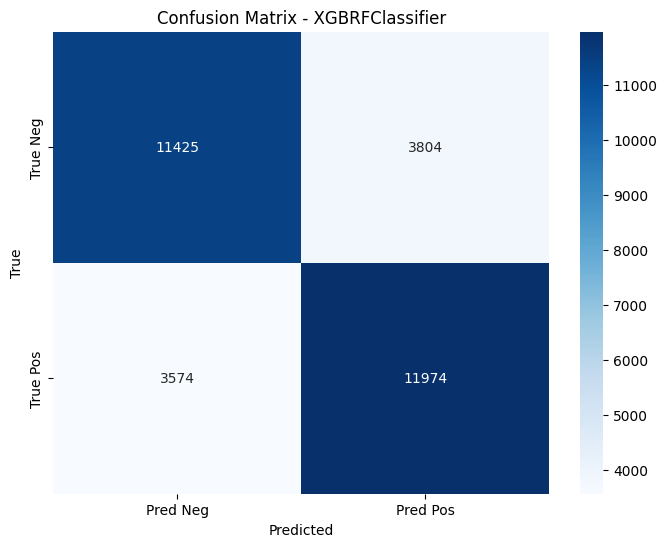


Total Correct: 23399 (76.03%)
------------------------------------------------------------
True Positives (TP): 11974 (38.91%)
True Negatives (TN): 11425 (37.12%)

Total Errors: 7378 (23.97%)
------------------------------------------------------------
False Positives (FP): 3804 (12.36%)
False Negatives (FN): 3574 (11.61%)


In [ ]:
# Plot Confusion Matrix
plot_confusion_matrix(random_search_xgboost.best_estimator_, X_test, y_test, model_name_best_xgboost)


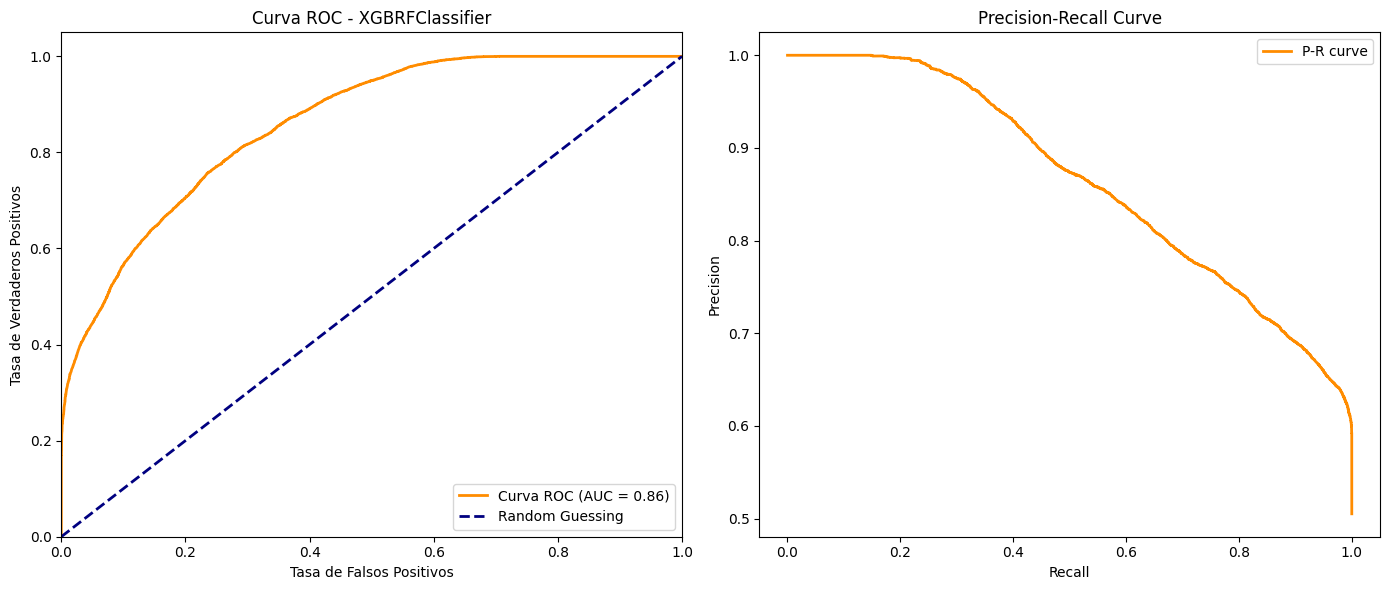

In [ ]:
# Plot Curvas ROC y P-R
plot_roc_pr_curves(random_search_xgboost.best_estimator_, X_test, y_test, model_name_best_xgboost)


In [ ]:

# Guardar resultados en archivo CSV
save_score(y_train, train_preds_best_xgboost, model_name_best_xgboost, train=True)
save_score(y_test, test_preds_best_xgboost, model_name_best_xgboost, train=False)


## SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

target = 'loan_status'
X = df.drop(columns=[target])
y = df[target]

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definición de hiperparámetros para SVM
svm_params = {
    'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
    'C': [0.001, 0.1, 0.5, 1, 5, 10, 100],
    'degree': [1, 2, 3, 4],
    'gamma': ['scale', 'auto']
}

# Búsqueda aleatoria de hiperparámetros para SVM
svm_search = SVC()
rs_svm = RandomizedSearchCV(svm_search, svm_params, n_iter=10, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
rs_svm.fit(X_train, y_train)

# Resultados de la búsqueda aleatoria de hiperparámetros
print(f'\nMejores parámetros (búsqueda aleatoria): {rs_svm.best_params_}')
print(f'Precisión en el conjunto de entrenamiento (búsqueda aleatoria): {rs_svm.best_score_:.4f}')

# Entrenamiento del modelo con los mejores hiperparámetros
best_svm_model = rs_svm.best_estimator_
best_svm_model.fit(X_train, y_train)

# Evaluación en el conjunto de prueba
preds_svm = best_svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, preds_svm)
recall_svm = recall_score(y_test, preds_svm)

print(f'Precisión en el conjunto de prueba (SVM): {accuracy_svm:.4f}')
print(f'Recall en el conjunto de prueba (SVM): {recall_svm:.4f}')


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
# Llamada a las funciones después de entrenar el modelo
train_preds_svm = best_svm_model.predict(X_train)
test_preds_svm = preds_svm

model_name_svm = 'SVM'
print_score(y_train, train_preds_svm, model_name_svm, train=True)
print_score(y_test, test_preds_svm, model_name_svm, train=False)

plot_confusion_matrix(best_svm_model, X_test, y_test, model_name_svm)
plot_roc_pr_curves(best_svm_model, X_test, y_test, model_name_svm)

save_score(y_train, train_preds_svm, model_name_svm, train=True)
save_score(y_test, test_preds_svm, model_name_svm, train=False)

NameError: name 'best_svm_model' is not defined

## KNN

In [ ]:
# Creacion del modelo - KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score 

target = 'loan_status'
X = df.drop(columns=[target])
y = df[target]

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarización de datos
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Modelo KNN con hiperparámetros específicos
knn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')

# Entrenamiento del modelo
knn_model.fit(X_train_std, y_train)

# Evaluación en el conjunto de prueba
preds_knn = knn_model.predict(X_test_std)
accuracy_knn = accuracy_score(y_test, preds_knn)
recall_knn = recall_score(y_test, preds_knn)

print(f'Precisión en el conjunto de prueba (KNN): {accuracy_knn:.4f}')
print(f'Recall en el conjunto de prueba (KNN): {recall_knn:.4f}')

# Definición de hiperparámetros para KNN
knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Búsqueda aleatoria de hiperparámetros para KNN
knn_search = KNeighborsClassifier()
rs_knn = RandomizedSearchCV(knn_search, knn_params, n_iter=10, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)
rs_knn.fit(X_train_std, y_train)

# Resultados de la búsqueda aleatoria de hiperparámetros
print(f'\nMejores parámetros (búsqueda aleatoria): {rs_knn.best_params_}')
print(f'Precisión en el conjunto de entrenamiento (búsqueda aleatoria): {rs_knn.best_score_:.4f}')

# Entrenamiento del modelo con los mejores hiperparámetros
best_knn_model = rs_knn.best_estimator_
best_knn_model.fit(X_train_std, y_train)

# Evaluación en el conjunto de prueba
preds_knn = best_knn_model.predict(X_test_std)
accuracy_knn = accuracy_score(y_test, preds_knn)
recall_knn = recall_score(y_test, preds_knn)


Precisión en el conjunto de prueba (KNN): 0.7600
Recall en el conjunto de prueba (KNN): 0.7665
Fitting 10 folds for each of 10 candidates, totalling 100 fits

Mejores parámetros (búsqueda aleatoria): {'weights': 'distance', 'n_neighbors': 9, 'algorithm': 'ball_tree'}
Precisión en el conjunto de entrenamiento (búsqueda aleatoria): 0.7686


Train Result:
Accuracy Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                 0        1  accuracy  macro avg  weighted avg
precision     1.00     1.00      1.00       1.00          1.00
recall        1.00     1.00      1.00       1.00          1.00
f1-score      1.00     1.00      1.00       1.00          1.00
support   61712.00 61393.00      1.00  123105.00     123105.00
_______________________________________________
Confusion Matrix: 
 [[61712     0]
 [    0 61393]]

Test Result:
Accuracy Score: 76.87%
_______________________________________________
CLASSIFICATION REPORT:
                 0        1  accuracy  macro avg  weighted avg
precision     0.77     0.77      0.77       0.77          0.77
recall        0.76     0.78      0.77       0.77          0.77
f1-score      0.76     0.77      0.77       0.77          0.77
support   15229.00 15548.00      0.77   30777.00      30777.00
_______________________________________________
Confus

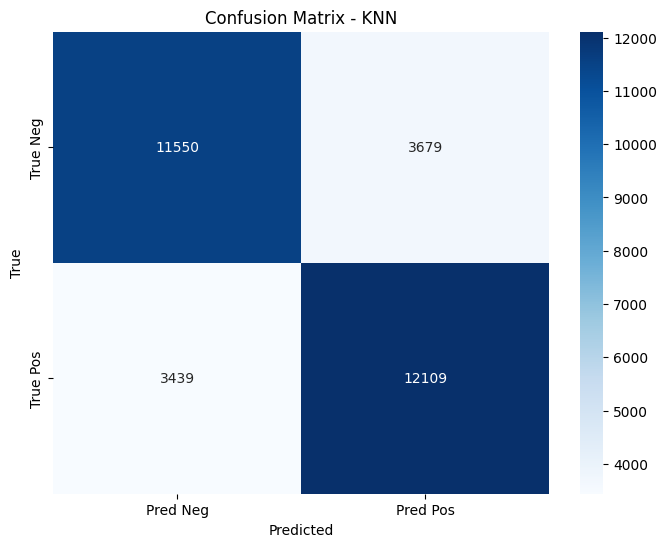


Total Correct: 23659 (76.87%)
------------------------------------------------------------
True Positives (TP): 12109 (39.34%)
True Negatives (TN): 11550 (37.53%)

Total Errors: 7118 (23.13%)
------------------------------------------------------------
False Positives (FP): 3679 (11.95%)
False Negatives (FN): 3439 (11.17%)


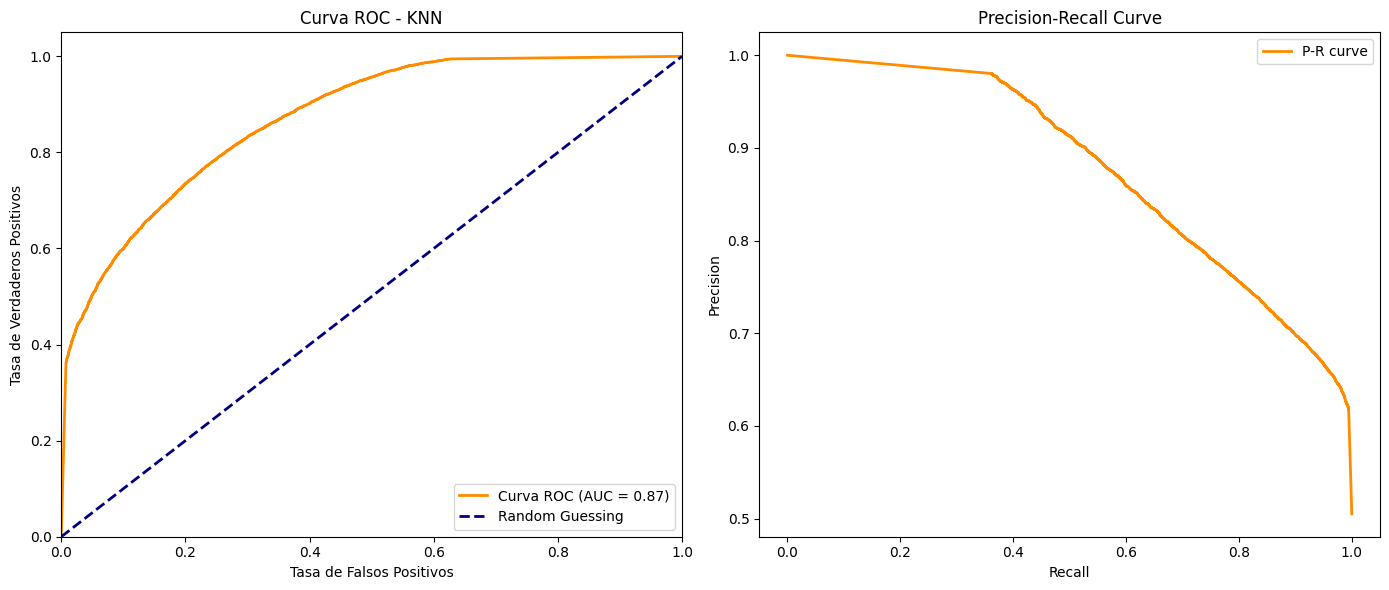

In [ ]:
# Llamada a las funciones después de entrenar el modelo
train_preds_knn = best_knn_model.predict(X_train_std)
test_preds_knn = preds_knn

model_name_knn = 'KNN'
print_score(y_train, train_preds_knn, model_name_knn, train=True)
print_score(y_test, test_preds_knn, model_name_knn, train=False)

plot_confusion_matrix(best_knn_model, X_test_std, y_test, model_name_knn)
plot_roc_pr_curves(best_knn_model, X_test_std, y_test, model_name_knn)

save_score(y_train, train_preds_knn, model_name_knn, train=True)
save_score(y_test, test_preds_knn, model_name_knn, train=False)

# ANN

C:\Users\Admin\AppData\Local\Temp\ipykernel_8484\2558788006.py:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Reloading Tuner from my_dir\my_project\tuner0.json
Epoch 1/20
3848/3848 [==============================] - 15s 3ms/step - loss: 0.3976 - AUC: 0.8853 - val_loss: 0.3620 - val_AUC: 0.9024
Epoch 2/20
3848/3848 [==============================] - 13s 3ms/step - loss: 0.3691 - AUC: 0.8988 - val_loss: 0.3606 - val_AUC: 0.9039
Epoch 3/20
3848/3848 [==============================] - 13s 3ms/step - loss: 0.3651 - AUC: 0.9008 - val_loss: 0.3592 - val_AUC: 0.9037
Epoch 4/20
3848/3848 [==============================] - 13s 3ms/step - loss: 0.3626 - AUC: 0.9022 - val_loss: 0.3598 - val_AUC: 0.9046
Epoch 5/20
3848/3848 [==============================] - 13s 3ms/step - loss: 0.3610 - AUC: 0.9031 - val_loss: 0.3584 - val_AUC: 0.9047
Epoch 6/20
3848/3848 [==============================] - 13s 3ms/step - loss: 0.3609 - AUC: 0.9033 - val_loss: 0.3598 - val_AUC: 0.9049
Epoch 7/20
3848/3848 [==============================] - 13s 3ms/step - loss: 0.3600 - AUC: 0.9037 - val_loss: 0.3587 - val_AUC: 0.9047
Epoc

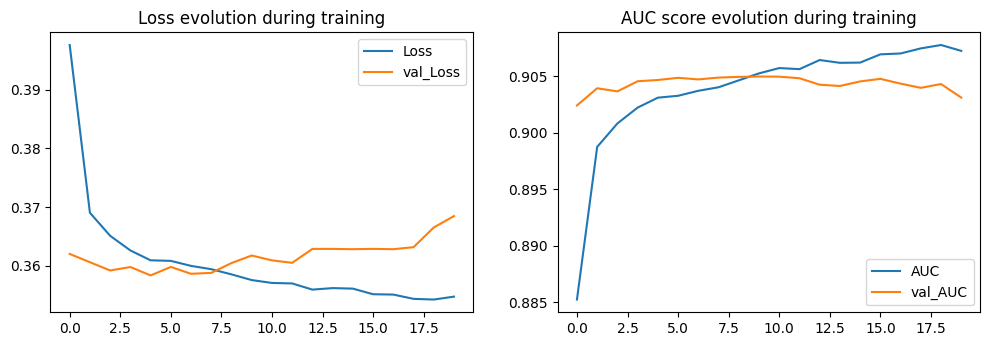

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kerastuner.tuners import RandomSearch

target = 'loan_status'
X = df.drop(columns=[target])
y = df[target]

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def evaluate_nn(true, pred, train=True):
    # Convierte las predicciones a etiquetas de clase binarias
    pred_bin = [1 if p >= 0.5 else 0 for p in pred]

    if train:
        clf_report = pd.DataFrame(classification_report(true, pred_bin, output_dict=True))
        acc = accuracy_score(true, pred_bin) * 100

        print("Train Result:\n================================================")
        print(f"Accuracy Score: {acc:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred_bin)}\n")

    elif not train:
        clf_report = pd.DataFrame(classification_report(true, pred_bin, output_dict=True))
        acc = accuracy_score(true, pred_bin) * 100

        print("Test Result:\n================================================")
        print(f"Accuracy Score: {acc:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred_bin)}\n")

def plot_learning_evolution(r):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during training')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['AUC'], label='AUC')
    plt.plot(r.history['val_AUC'], label='val_AUC')
    plt.title('AUC score evolution during training')
    plt.legend();

def build_model(hp):
    num_columns = X_train.shape[1]
    num_labels = 1

    model = keras.Sequential()

    model.add(layers.BatchNormalization(input_shape=(num_columns,)))

    # Tune the number of layers and units in each layer
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(layers.Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
                               activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(layers.Dense(num_labels, activation='sigmoid'))

    # Tune the learning rate
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(name='AUC')])

    return model

tuner = RandomSearch(
    build_model,
    objective='val_AUC',
    max_trials=5,  # Número de combinaciones de hiperparámetros a probar
    directory='my_dir',
    project_name='my_project'
)

# Normalización de datos
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Asegurarse de que los datos sean de tipo float32
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Obtiene los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Construir el modelo con los mejores hiperparámetros y entrenar
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Evaluar el modelo y mostrar resultados
evaluate_nn(y_test, best_model.predict(X_test), train=False)
plot_learning_evolution(history)

In [ ]:
# Obtener las predicciones del modelo
threshold = 0.5  # Umbral para convertir probabilidades en clases
train_preds_ann = (best_model.predict(X_train) > threshold).astype(int)
test_preds_ann = (best_model.predict(X_test) > threshold).astype(int)

model_name = 'ANN'

print_score(y_train, train_preds_ann, model_name, train=True)
print_score(y_test, test_preds_ann, model_name, train=False)


962/962 [==============================] - 1s 1ms/step
Train Result:
Accuracy Score: 81.04%
_______________________________________________
CLASSIFICATION REPORT:
               0.0      1.0  accuracy  macro avg  weighted avg
precision     0.83     0.79      0.81       0.81          0.81
recall        0.78     0.84      0.81       0.81          0.81
f1-score      0.81     0.81      0.81       0.81          0.81
support   61712.00 61393.00      0.81  123105.00     123105.00
_______________________________________________
Confusion Matrix: 
 [[48413 13299]
 [10038 51355]]

Test Result:
Accuracy Score: 80.07%
_______________________________________________
CLASSIFICATION REPORT:
               0.0      1.0  accuracy  macro avg  weighted avg
precision     0.81     0.79      0.80       0.80          0.80
recall        0.77     0.83      0.80       0.80          0.80
f1-score      0.79     0.81      0.80       0.80          0.80
support   15229.00 15548.00      0.80   30777.00      30777.00


In [ ]:
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, classification_report, accuracy_score

def plot_confusion_matrix(model, X_test, y_test, model_name):
    # Predicciones del modelo
    preds = (model.predict(X_test) > 0.5).astype(int)

    # Convertir a tipo entero
    y_test = y_test.astype(int)
    preds = preds.astype(int)

    # Matriz de confusión
    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.ravel()
    
    # Configurar el gráfico
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Pred Neg', 'Pred Pos'], yticklabels=['True Neg', 'True Pos'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    # Calcular porcentajes
    total = tn + fp + fn + tp
    accuracy = (tp + tn) / total * 100
    error_rate = (fp + fn) / total * 100
    precision = tp / (tp + fp) * 100 if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) * 100 if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    # Calcular total de positivos y negativos con sus porcentajes
    total_correct = tp + tn
    total_errors = fp + fn
    percent_correct = total_correct / total * 100
    percent_errors = total_errors / total * 100

    # Mostrar resultados
    print(f"\nTotal Correct: {total_correct} ({percent_correct:.2f}%)")
    print('--'*30)
    print(f"True Positives (TP): {tp} ({tp/total*100:.2f}%)")
    print(f"True Negatives (TN): {tn} ({tn/total*100:.2f}%)")

    print(f"\nTotal Errors: {total_errors} ({percent_errors:.2f}%)")
    print('--'*30)
    print(f"False Positives (FP): {fp} ({fp/total*100:.2f}%)")
    print(f"False Negatives (FN): {fn} ({fn/total*100:.2f}%)")
    print(f"\nAccuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1 Score: {f1:.2f}%")

def plot_roc_pr_curves(model, X_test, y_test, model_name):
    # Obtener las probabilidades de la clase positiva
    y_test_probs = model.predict(X_test)

    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
    roc_auc = roc_auc_score(y_test, y_test_probs)

    # Curva P-R
    precision, recall, _ = precision_recall_curve(y_test, y_test_probs)

    # Crear la figura con dos subgráficos
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Graficar Curva ROC
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('Tasa de Falsos Positivos')
    ax1.set_ylabel('Tasa de Verdaderos Positivos')
    ax1.set_title(f'Curva ROC - {model_name}')
    ax1.legend(loc='lower right')

    # Graficar Curva P-R
    ax2.plot(recall, precision, color='darkorange', lw=2, label='P-R curve')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title(f'Precision-Recall Curve - {model_name}')
    ax2.legend()

    # Mostrar resultados
    plt.tight_layout()
    plt.show()


from pathlib import Path

def save_score(true, pred, model_name, train=True, auc_roc=None):
    timestamp = datetime.now().strftime('%Y%m')
    file_name = f"{model_name}_TestResults_{timestamp}.csv"

    clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
    accuracy = accuracy_score(true, pred) * 100
    confusion = confusion_matrix(true, pred)

    if auc_roc is not None:
        result_df = pd.DataFrame({
            'Set': ['Train' if train else 'Test'],
            'Accuracy': [accuracy],
            'AUC-ROC': [auc_roc],
            'Classification Report': [clf_report.to_dict()],
            'Confusion Matrix': [confusion.tolist()]
        })
    else:
        result_df = pd.DataFrame({
            'Set': ['Train' if train else 'Test'],
            'Accuracy': [accuracy],
            'Classification Report': [clf_report.to_dict()],
            'Confusion Matrix': [confusion.tolist()]
        })

    # Obtener la ruta completa del directorio 'resultado modelos'
    resultados_dir = Path.cwd() / 'resultado modelos'
    resultados_dir.mkdir(exist_ok=True)  # Crear el directorio si no existe

    # Unir la ruta del directorio 'resultado modelos' con el nombre del archivo CSV
    file_path = resultados_dir / file_name

    # Guardar el DataFrame en el archivo CSV
    result_df.to_csv(file_path, index=False)

    print(f"Salvado en: {file_path}")



  27/3848 [..............................] - ETA: 7s  

962/962 [==============================] - 1s 1ms/step


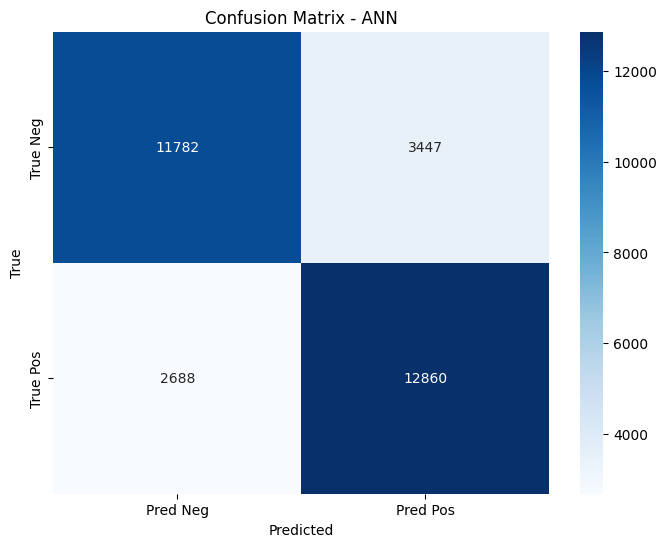


Total Correct: 24642 (80.07%)
------------------------------------------------------------
True Positives (TP): 12860 (41.78%)
True Negatives (TN): 11782 (38.28%)

Total Errors: 6135 (19.93%)
------------------------------------------------------------
False Positives (FP): 3447 (11.20%)
False Negatives (FN): 2688 (8.73%)

Accuracy: 80.07%
Precision: 78.86%
Recall: 82.71%
F1 Score: 80.74%
962/962 [==============================] - 1s 1ms/step


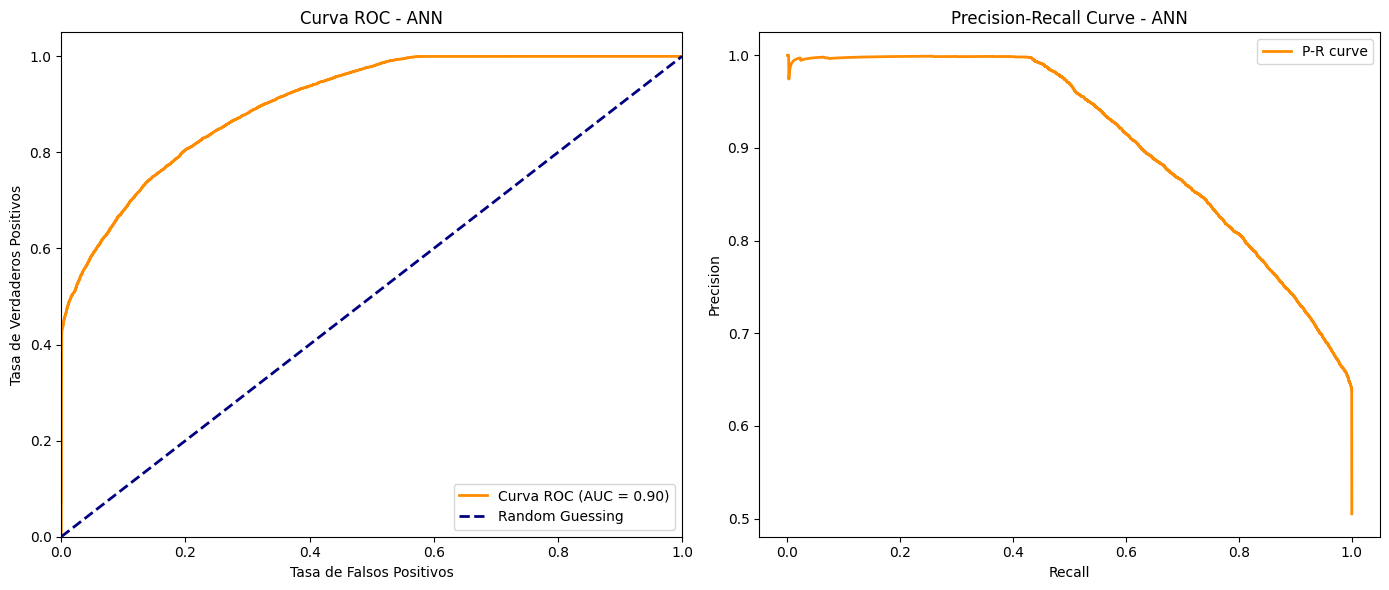

In [ ]:
# Obtener las predicciones del modelo
threshold = 0.5  # Umbral para convertir probabilidades en clases
train_preds_ann = (best_model.predict(X_train) > threshold).astype(int)
test_preds_ann = (best_model.predict(X_test) > threshold).astype(int)

model_name = 'ANN'

plot_confusion_matrix(best_model, X_test, y_test, model_name)
plot_roc_pr_curves(best_model, X_test, y_test, model_name)

In [ ]:
# Obtener las predicciones del modelo
threshold = 0.5  # Umbral para convertir probabilidades en clases
train_preds_ann = (best_model.predict(X_train) > threshold).astype(int)
test_preds_ann = (best_model.predict(X_test) > threshold).astype(int)

model_name = 'ANN'
# Llamada a funciones:
save_score(y_train, train_preds_ann, model_name, train=True)
save_score(y_test, test_preds_ann, model_name, train=False)

962/962 [==============================] - 1s 1ms/step


AttributeError: module 'datetime' has no attribute 'now'

In [ ]:
# Creacion de modelo - ANN con Gridsearch/Pippeline
'''
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline


target = 'loan_status'
X = df.drop(columns=[target])
y = df[target]

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline para ANN
pca_ann = PCA(n_components=None) # None/0.95
ann = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', pca_ann),
    ('selectkbest', SelectKBest()),
    ('ann', MLPClassifier())
])

# Parámetros para ANN
ann = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=None)),
    ('selectkbest', SelectKBest()),
    ('ann', MLPClassifier())
])

# Parameters for ANN
ann_params = {
    'selectkbest__k': [2, 3, 4],
    'ann__hidden_layer_sizes': [(100,), (50, 50), (30, 20, 10)],
    'ann__activation': ['relu', 'tanh', 'logistic'],
    'ann__solver': ['sgd', 'adam'],
    'ann__alpha': [0.0001, 0.001, 0.01],
    'ann__learning_rate': ['constant', 'invscaling', 'adaptive'],
}

# Grid search with ANN model
gs_ann = GridSearchCV(ann, ann_params, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)

# Train the grid search
gs_ann.fit(X_train, y_train)

# Access the best estimator from cv_results_
best_ann_estimator = gs_ann.best_estimator_

# Results of the grid search for ANN
print(f'Accuracy on the training set: {gs_ann.best_score_:.4f}')
print(f'Best parameters: {gs_ann.best_params_}')
print('Best estimator:')
print(best_ann_estimator)

# Accuracy, recall, precision, and F1 score on the test set
train_preds_ann = best_ann_estimator.predict(X_train)
test_preds_ann = best_ann_estimator.predict(X_test)
accuracy = accuracy_score(y_test, test_preds_ann)
recall = recall_score(y_test, test_preds_ann)
precision = precision_score(y_test, test_preds_ann)
f1 = f1_score(y_test, test_preds_ann)

print(f'Accuracy on the test set: {accuracy:.4f}')
print(f'Recall on the test set: {recall:.4f}')
print(f'Precision on the test set: {precision:.4f}')
print(f'F1 score on the test set: {f1:.4f}')
'''

---

In [ ]:
# Bloque 1: Comparación Numérica y Gráfica de Métricas ['Accuracy', 'Precision', 'Recall', 'F1-score']

# Extracción de las métricas
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
df_metrics = df_all_models.loc[:, metrics].reset_index()

# Comparación Numérica
print(df_metrics)

# Comparación Gráfica
plt.figure(figsize=(12, 8))
sns.barplot(x='level_0', y='value', hue='level_1', data=pd.melt(df_metrics, id_vars=['level_0'], value_vars=metrics))
plt.title('Comparación de Métricas entre Modelos')
plt.xlabel('Modelo')
plt.ylabel('Valor')
plt.show()

NameError: name 'df_all_models' is not defined

In [ ]:
# Bloque 2: Comparación Numérica y Gráfica de la Métrica AUC-ROC (%)

# Lista de DataFrames
dfs = []

# Definición de modelos
models = {
    'Logistic Regression': gs_reg_log.best_estimator_,
    'Random Forest': gs_rand_forest.best_estimator_,
    'XGBRF Classifier': gs_xgboost.best_estimator_,
    'SVM': gs_svm.best_estimator_,
    'KNN': gs_knn.best_estimator_,
    'ANN': gs_ann.best_estimator_,
}

# Extracción de la columna AUC-ROC
df_roc_auc = df_all_models['AUC-ROC'].reset_index()

# Comparación Numérica
print(df_roc_auc)

# Comparación Gráfica
plt.figure(figsize=(12, 8))
sns.barplot(x='level_0', y='AUC-ROC', data=df_roc_auc)
plt.title('Comparación de AUC-ROC entre Modelos')
plt.xlabel('Modelo')
plt.ylabel('AUC-ROC (%)')
plt.show()

NameError: name 'gs_reg_log' is not defined

Comparativa

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carga de los DataFrames
df_lr = pd.read_csv('./3_ML/Pruebas/LogisticRegression_202311.csv')
df_rf = pd.read_csv('./3_ML/Pruebas/RandomForest_202311.csv')
df_xg = pd.read_csv('./3_ML/Pruebas/XGBRFClassifier_202311.csv')
df_svm = pd.read_csv('./3_ML/Pruebas/SVM_202311.csv')
df_knn = pd.read_csv('./3_ML/Pruebas/KNN_202311.csv')
df_ann = pd.read_csv('./3_ML/Pruebas/ANN_202311.csv')

# Concatenación de los DataFrames
df_all_models = pd.concat([df_lr, df_rf, df_xg, df_svm, df_knn, df_ann], keys=['LogisticRegression', 'RandomForest', 'XGBRFClassifier', 'SVM', 'KNN', 'ANN'])


FileNotFoundError: [Errno 2] No such file or directory: './3_ML/Pruebas/LogisticRegression_202311.csv'

In [ ]:
# Bloque 1: Comparación Numérica y Gráfica de Métricas ['Accuracy', 'Precision', 'Recall', 'F1-score']

# Extracción de las métricas
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
df_metrics = df_all_models.loc[:, metrics].reset_index()

# Comparación Numérica
print(df_metrics)

# Comparación Gráfica
plt.figure(figsize=(12, 8))
sns.barplot(x='level_0', y='value', hue='level_1', data=pd.melt(df_metrics, id_vars=['level_0'], value_vars=metrics))
plt.title('Comparación de Métricas entre Modelos')
plt.xlabel('Modelo')
plt.ylabel('Valor')
plt.show()

In [ ]:
# Bloque 2: Comparación Numérica y Gráfica de la Métrica AUC-ROC (%)

# Lista de DataFrames
dfs = []

# Definición de modelos
models = {
    'Logistic Regression': gs_reg_log.best_estimator_,
    'Random Forest': gs_rand_forest.best_estimator_,
    'XGBRF Classifier': gs_xgboost.best_estimator_,
    'SVM': gs_svm.best_estimator_,
    'KNN': gs_knn.best_estimator_,
    'ANN': gs_ann.best_estimator_,
}

# Extracción de la columna AUC-ROC
df_roc_auc = df_all_models['AUC-ROC'].reset_index()

# Comparación Numérica
print(df_roc_auc)

# Comparación Gráfica
plt.figure(figsize=(12, 8))
sns.barplot(x='level_0', y='AUC-ROC', data=df_roc_auc)
plt.title('Comparación de AUC-ROC entre Modelos')
plt.xlabel('Modelo')
plt.ylabel('AUC-ROC (%)')
plt.show()

NameError: name 'gs_reg_log' is not defined

----------------

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score

# Lista de modelos y archivos CSV correspondientes
model_names = ['LogisticRegression', 'RandomForest', 'XGBRFClassifier', 'SVM', 'KNN', 'ANN']
csv_files = ['LogisticRegression_202311.csv', 'RandomForest_202311.csv',
             'XGBRFClassifier_TestResults_202311.csv', 'SVM_TestResults_202311.csv',
             'KNN_TestResults_202311.csv', 'ANN_TestResults_202311.csv']

# Crear un DataFrame para comparar resultados
results_df = pd.DataFrame(index=model_names, columns=['Accuracy', 'Recall'])

# Calcular métricas para cada modelo
for model_name, csv_file in zip(model_names, csv_files):
    df = pd.read_csv(csv_file)
    y_true = df['y_true_test']
    y_pred = df['y_pred_test']
    
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    results_df.loc[model_name, 'Accuracy'] = accuracy
    results_df.loc[model_name, 'Recall'] = recall

# Imprimir el DataFrame con los resultados
print(results_df)

FileNotFoundError: [Errno 2] No such file or directory: 'LogisticRegression_202311.csv'

In [ ]:
# Crear un DataFrame vacío
results_df = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1_score'])

models = {
    model_name='Logistic Regression',
    #'Logistic Regression': gs_reg_log.best_estimator_,
    model_name='Random Forest',
    #'Random Forest': gs_rand_forest.best_estimator_,
    model_name='XGBRF Classifier',
    #'XGBRF Classifier': gs_xgboost.best_estimator_,
    model_name='SVM',
    #'SVM': gs_svm.best_estimator_,
    model_name='KNN',
    #'KNN': gs_knn.best_estimator_,
    model_name='ANN',
    #'ANN': gs_ann.best_estimator_,
    }

# Iterar sobre los resultados y añadirlos al DataFrame
for model_name, result in zip(models, save_score):
    results_df.loc[model_name] = result

# Mostrar el DataFrame
print(results_df)

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Regresión Logística:

In [ ]:
# Regresión Logística:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score 
from sklearn.model_selection import train_test_split

# Suponiendo que df es tu DataFrame y 'Star Rating' es tu columna objetivo
target = 'loan_status'
X = df.drop(columns=[target])
y = df[target]

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instanciamos el PCA y el pipeline para Regresión Logística
pca = PCA(n_components=0.95)  # Elige el número de componentes que explica al menos el 95% de la varianza
reg_log = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', pca),
    ('reglog', LogisticRegression(max_iter=1000, solver='liblinear'))
])

# Parámetros de modelo 1
reg_log_params = {
    'reglog__penalty': ['l1', 'l2'],
    'reglog__C': np.logspace(0, 4, 10)
}

# Grid search con modelo 1
gs_reg_log = GridSearchCV(reg_log, reg_log_params, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)

# Entrenamos el grid search
gs_reg_log.fit(X_train, y_train)

# Resultados del grid search para Regresión Logística
print(f'Precisión en el conjunto de entrenamiento: {gs_reg_log.best_score_:.4f}')
print(f'Mejores parámetros: {gs_reg_log.best_params_}')

# Precisión y recall en el conjunto de prueba
preds = gs_reg_log.best_estimator_.predict(X_test)
accuracy_test = accuracy_score(y_test, preds)
recall_test = recall_score(y_test, preds)

print(f'Precisión en el conjunto de prueba: {accuracy_test:.4f}')
print(f'Recall en el conjunto de prueba: {recall_test:.4f}')

Fitting 10 folds for each of 20 candidates, totalling 200 fits


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score 
from sklearn.model_selection import train_test_split

# Suponiendo que df es tu DataFrame y 'Star Rating' es tu columna objetivo
target = 'loan_status'
X = df.drop(columns=[target])
y = df[target]

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instanciamos el clasificador Random Forest
rand_forest = RandomForestClassifier()

# Parámetros del modelo Random Forest
rand_forest_params = {
    'n_estimators': [10, 100, 1000],
    'max_features': [1, 2, 3]
}

# Grid search con modelo Random Forest
gs_rand_forest = GridSearchCV(rand_forest, rand_forest_params, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)

# Entrenamos el grid search
gs_rand_forest.fit(X_train, y_train)

# Resultados del grid search para Random Forest
print(f'Precisión en el conjunto de entrenamiento: {gs_rand_forest.best_score_:.4f}')
print(f'Mejores parámetros: {gs_rand_forest.best_params_}')
print('Mejor estimador:')
print(gs_rand_forest.best_estimator_)

# Precisión y recall en el conjunto de prueba
preds = gs_rand_forest.best_estimator_.predict(X_test)
accuracy_test = accuracy_score(y_test, preds)
recall_test = recall_score(y_test, preds)

print(f'Precisión en el conjunto de prueba: {accuracy_test:.4f}')
print(f'Recall en el conjunto de prueba: {recall_test:.4f}')

XG Boost

In [ ]:
from xgboost import XGBRFClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score 
from sklearn.model_selection import train_test_split

# Suponiendo que df es tu DataFrame y 'Star Rating' es tu columna objetivo
target = 'Star Rating'
X = df.drop(columns=[target])
y = df[target]

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline para XGBoost
xgboost = Pipeline(steps=[
    ('classifier', XGBRFClassifier(random_state=42))
])

# Parámetros para XGBoost
xgboost_params = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.1, 0.5, 1.0],
    'classifier__max_depth': [2, 3, 4],
    'classifier__subsample': [0.8, 1.0],
}

# Grid search con modelo XGBoost
gs_xgboost = GridSearchCV(xgboost, xgboost_params, cv=10, scoring='accuracy', verbose=0, n_jobs=-1)

# Entrenamos el grid search
gs_xgboost.fit(X_train, y_train)

# Resultados del grid search para XGBoost
print(f'Precisión en el conjunto de entrenamiento: {gs_xgboost.best_score_:.4f}')
print(f'Mejores parámetros: {gs_xgboost.best_params_}')
print('Mejor estimador:')
print(gs_xgboost.best_estimator_)

# Precisión y recall en el conjunto de prueba
preds = gs_xgboost.best_estimator_.predict(X_test)
accuracy_test = accuracy_score(y_test, preds)
recall_test = recall_score(y_test, preds)

print(f'Precisión en el conjunto de prueba: {accuracy_test:.4f}')
print(f'Recall en el conjunto de prueba: {recall_test:.4f}')

SVM

In [ ]:
'''
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score 
from sklearn.model_selection import train_test_split

# Suponiendo que df es tu DataFrame y 'Star Rating' es tu columna objetivo
target = 'Star Rating'
X = df.drop(columns=[target])
y = df[target]

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline para SVM
svm = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('selectkbest', SelectKBest()),
    ('svm', SVC())
])

# Parámetros para SVM
svm_params = {
    'selectkbest__k': [2, 3, 4],
    'svm__kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
    'svm__C': [0.001, 0.1, 0.5, 1, 5, 10, 100],
    'svm__degree': [1, 2, 3, 4],
    'svm__gamma': ['scale', 'auto']
}

# Grid search con modelo SVM
gs_svm = GridSearchCV(svm, svm_params, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)

# Entrenamos el grid search
gs_svm.fit(X_train, y_train)

# Resultados del grid search para SVM
print(f'Precisión en el conjunto de entrenamiento: {gs_svm.best_score_:.4f}')
print(f'Mejores parámetros: {gs_svm.best_params_}')
print('Mejor estimador:')
print(gs_svm.best_estimator_)

# Precisión y recall en el conjunto de prueba
preds = gs_svm.best_estimator_.predict(X_test)
accuracy_test = accuracy_score(y_test, preds)
recall_test = recall_score(y_test, preds)

print(f'Precisión en el conjunto de prueba: {accuracy_test:.4f}')
print(f'Recall en el conjunto de prueba: {recall_test:.4f}')
'''

In [ ]:
print('--'*20)

In [ ]:
import pandas as pd

def buscar_ceros(df):
    # Obtener una lista de columnas numéricas
    columnas_numericas = df.select_dtypes(include='number').columns
    
    # Obtener el número total de filas en el DataFrame
    total_filas = len(df)
    
    # Iterar sobre las columnas y buscar ceros
    for columna in columnas_numericas:
        ceros_en_columna = (df[columna] == 0).sum()
        porcentaje_ceros = (ceros_en_columna / total_filas) * 100
        
        if ceros_en_columna > 0:
            print(f"'{columna}': {ceros_en_columna} ceros ({porcentaje_ceros:.2f}% )")


buscar_ceros(df)

'loan_status': 76941 ceros (19.67% )
'dti': 282 ceros (0.07% )
'pub_rec': 333936 ceros (85.36% )
'revol_bal': 1856 ceros (0.47% )
'revol_util': 2128 ceros (0.54% )
'mort_acc': 152256 ceros (38.92% )
'pub_rec_bankruptcies': 346295 ceros (88.52% )


In [ ]:
df1.columns

NameError: name 'df1' is not defined

In [ ]:
import pandas as pd
data_01=pd.read_csv('./3_ML/Pruebas/Prueba_REGR LOGST_test_2023-11.csv')
data_01

,Actual,Predicted,REGR LOGST_datetime,REGR LOGST_accuracy,REGR LOGST_precision,REGR LOGST_recall,REGR LOGST_f1_score,REGR LOGST_roc_auc,REGR LOGST_confusion_matrix
0,0,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623]
1,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623]
2,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623]
3,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623]
4,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623]
...,...,...,...,...,...,...,...,...,...
79039,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623]
79040,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623]
79041,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623]
79042,0,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623]


In [ ]:
import pandas as pd
data_02=pd.read_csv('./3_ML/Pruebas/Prueba_DECISION TREE_test_2023-11.csv')
data_02

,Actual,Predicted,REGR LOGST_datetime,REGR LOGST_accuracy,REGR LOGST_precision,REGR LOGST_recall,REGR LOGST_f1_score,REGR LOGST_roc_auc,REGR LOGST_confusion_matrix,DECISION TREE_datetime,DECISION TREE_accuracy,DECISION TREE_precision,DECISION TREE_recall,DECISION TREE_f1_score,DECISION TREE_roc_auc,DECISION TREE_confusion_matrix
0,0,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,[ 6639 8782 0 63623]
1,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,[ 6639 8782 0 63623]
2,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,[ 6639 8782 0 63623]
3,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,[ 6639 8782 0 63623]
4,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,[ 6639 8782 0 63623]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79039,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,[ 6639 8782 0 63623]
79040,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,[ 6639 8782 0 63623]
79041,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,[ 6639 8782 0 63623]
79042,0,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,[ 6639 8782 0 63623]


In [ ]:
import pandas as pd
data_03=pd.read_csv('./3_ML/Pruebas/Prueba_RNDM FRST_test_2023-11.csv')
data_03

,Actual,Predicted,REGR LOGST_datetime,REGR LOGST_accuracy,REGR LOGST_precision,REGR LOGST_recall,REGR LOGST_f1_score,REGR LOGST_roc_auc,REGR LOGST_confusion_matrix,DECISION TREE_datetime,DECISION TREE_accuracy,DECISION TREE_precision,DECISION TREE_recall,DECISION TREE_f1_score,DECISION TREE_roc_auc,DECISION TREE_confusion_matrix,RNDM FRST_datetime,RNDM FRST_accuracy,RNDM FRST_precision,RNDM FRST_recall,RNDM FRST_f1_score,RNDM FRST_roc_auc,RNDM FRST_confusion_matrix
0,0,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,[ 6639 8782 0 63623],2023-11-14,0.89,0.88,0.99,0.94,0.73,[ 7055 8366 379 63244]
1,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,[ 6639 8782 0 63623],2023-11-14,0.89,0.88,0.99,0.94,0.73,[ 7055 8366 379 63244]
2,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,[ 6639 8782 0 63623],2023-11-14,0.89,0.88,0.99,0.94,0.73,[ 7055 8366 379 63244]
3,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,[ 6639 8782 0 63623],2023-11-14,0.89,0.88,0.99,0.94,0.73,[ 7055 8366 379 63244]
4,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,[ 6639 8782 0 63623],2023-11-14,0.89,0.88,0.99,0.94,0.73,[ 7055 8366 379 63244]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79039,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,[ 6639 8782 0 63623],2023-11-14,0.89,0.88,0.99,0.94,0.73,[ 7055 8366 379 63244]
79040,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,[ 6639 8782 0 63623],2023-11-14,0.89,0.88,0.99,0.94,0.73,[ 7055 8366 379 63244]
79041,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,[ 6639 8782 0 63623],2023-11-14,0.89,0.88,0.99,0.94,0.73,[ 7055 8366 379 63244]
79042,0,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,[ 6639 8782 0 63623],2023-11-14,0.89,0.88,0.99,0.94,0.73,[ 7055 8366 379 63244]


In [ ]:
import pandas as pd
data_04=pd.read_csv('./3_ML/Pruebas/Prueba_XGBOOST_test_2023-11.csv')
data_04

,Actual,Predicted,REGR LOGST_datetime,REGR LOGST_accuracy,REGR LOGST_precision,REGR LOGST_recall,REGR LOGST_f1_score,REGR LOGST_roc_auc,REGR LOGST_confusion_matrix,DECISION TREE_datetime,DECISION TREE_accuracy,DECISION TREE_precision,DECISION TREE_recall,DECISION TREE_f1_score,DECISION TREE_roc_auc,DECISION TREE_confusion_matrix,RNDM FRST_datetime,RNDM FRST_accuracy,RNDM FRST_precision,RNDM FRST_recall,RNDM FRST_f1_score,RNDM FRST_roc_auc,RNDM FRST_confusion_matrix,XGBOOST_datetime,XGBOOST_accuracy,XGBOOST_precision,XGBOOST_recall,XGBOOST_f1_score,XGBOOST_roc_auc,XGBOOST_confusion_matrix
0,0,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,[ 6639 8782 0 63623],2023-11-14,0.89,0.88,0.99,0.94,0.73,[ 7055 8366 379 63244],2023-11-14,0.89,0.89,0.99,0.94,0.73,[ 7375 8046 683 62940]
1,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,[ 6639 8782 0 63623],2023-11-14,0.89,0.88,0.99,0.94,0.73,[ 7055 8366 379 63244],2023-11-14,0.89,0.89,0.99,0.94,0.73,[ 7375 8046 683 62940]
2,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,[ 6639 8782 0 63623],2023-11-14,0.89,0.88,0.99,0.94,0.73,[ 7055 8366 379 63244],2023-11-14,0.89,0.89,0.99,0.94,0.73,[ 7375 8046 683 62940]
3,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,[ 6639 8782 0 63623],2023-11-14,0.89,0.88,0.99,0.94,0.73,[ 7055 8366 379 63244],2023-11-14,0.89,0.89,0.99,0.94,0.73,[ 7375 8046 683 62940]
4,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,[ 6639 8782 0 63623],2023-11-14,0.89,0.88,0.99,0.94,0.73,[ 7055 8366 379 63244],2023-11-14,0.89,0.89,0.99,0.94,0.73,[ 7375 8046 683 62940]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79039,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,[ 6639 8782 0 63623],2023-11-14,0.89,0.88,0.99,0.94,0.73,[ 7055 8366 379 63244],2023-11-14,0.89,0.89,0.99,0.94,0.73,[ 7375 8046 683 62940]
79040,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,[ 6639 8782 0 63623],2023-11-14,0.89,0.88,0.99,0.94,0.73,[ 7055 8366 379 63244],2023-11-14,0.89,0.89,0.99,0.94,0.73,[ 7375 8046 683 62940]
79041,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,[ 6639 8782 0 63623],2023-11-14,0.89,0.88,0.99,0.94,0.73,[ 7055 8366 379 63244],2023-11-14,0.89,0.89,0.99,0.94,0.73,[ 7375 8046 683 62940]
79042,0,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,[ 6639 8782 0 63623],2023-11-14,0.89,0.88,0.99,0.94,0.73,[ 7055 8366 379 63244],2023-11-14,0.89,0.89,0.99,0.94,0.73,[ 7375 8046 683 62940]


In [ ]:
import pandas as pd
data_05=pd.read_csv('./3_ML/Pruebas/Prueba_KNN_test_2023-11.csv')
data_05

,Actual,Predicted,REGR LOGST_datetime,REGR LOGST_accuracy,REGR LOGST_precision,REGR LOGST_recall,REGR LOGST_f1_score,REGR LOGST_roc_auc,REGR LOGST_confusion_matrix,DECISION TREE_datetime,DECISION TREE_accuracy,DECISION TREE_precision,DECISION TREE_recall,DECISION TREE_f1_score,DECISION TREE_roc_auc,...,RNDM FRST_confusion_matrix,XGBOOST_datetime,XGBOOST_accuracy,XGBOOST_precision,XGBOOST_recall,XGBOOST_f1_score,XGBOOST_roc_auc,XGBOOST_confusion_matrix,KNN_datetime,KNN_accuracy,KNN_precision,KNN_recall,KNN_f1_score,KNN_roc_auc,KNN_confusion_matrix
0,0,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,...,[ 7055 8366 379 63244],2023-11-14,0.89,0.89,0.99,0.94,0.73,[ 7375 8046 683 62940],2023-11-14,0.77,0.81,0.94,0.87,0.51,[ 1380 14041 4040 59583]
1,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,...,[ 7055 8366 379 63244],2023-11-14,0.89,0.89,0.99,0.94,0.73,[ 7375 8046 683 62940],2023-11-14,0.77,0.81,0.94,0.87,0.51,[ 1380 14041 4040 59583]
2,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,...,[ 7055 8366 379 63244],2023-11-14,0.89,0.89,0.99,0.94,0.73,[ 7375 8046 683 62940],2023-11-14,0.77,0.81,0.94,0.87,0.51,[ 1380 14041 4040 59583]
3,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,...,[ 7055 8366 379 63244],2023-11-14,0.89,0.89,0.99,0.94,0.73,[ 7375 8046 683 62940],2023-11-14,0.77,0.81,0.94,0.87,0.51,[ 1380 14041 4040 59583]
4,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,...,[ 7055 8366 379 63244],2023-11-14,0.89,0.89,0.99,0.94,0.73,[ 7375 8046 683 62940],2023-11-14,0.77,0.81,0.94,0.87,0.51,[ 1380 14041 4040 59583]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79039,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,...,[ 7055 8366 379 63244],2023-11-14,0.89,0.89,0.99,0.94,0.73,[ 7375 8046 683 62940],2023-11-14,0.77,0.81,0.94,0.87,0.51,[ 1380 14041 4040 59583]
79040,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,...,[ 7055 8366 379 63244],2023-11-14,0.89,0.89,0.99,0.94,0.73,[ 7375 8046 683 62940],2023-11-14,0.77,0.81,0.94,0.87,0.51,[ 1380 14041 4040 59583]
79041,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,...,[ 7055 8366 379 63244],2023-11-14,0.89,0.89,0.99,0.94,0.73,[ 7375 8046 683 62940],2023-11-14,0.77,0.81,0.94,0.87,0.51,[ 1380 14041 4040 59583]
79042,0,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,...,[ 7055 8366 379 63244],2023-11-14,0.89,0.89,0.99,0.94,0.73,[ 7375 8046 683 62940],2023-11-14,0.77,0.81,0.94,0.87,0.51,[ 1380 14041 4040 59583]


In [ ]:
from jsonschema import draft201909_format_checker
import pandas as pd
data_06=pd.read_csv('./3_ML/Pruebas/Prueba_ANN_test_2023-11.csv')
df2_test=data_06.copy()
df2_test

C:\Users\Admin\AppData\Local\Temp\ipykernel_8048\3046353406.py:1: DeprecationWarning: Accessing jsonschema.draft201909_format_checker is deprecated and will be removed in a future release. Instead, use the FORMAT_CHECKER attribute on the corresponding Validator.
  from jsonschema import draft201909_format_checker


,Actual,Predicted,REGR LOGST_datetime,REGR LOGST_accuracy,REGR LOGST_precision,REGR LOGST_recall,REGR LOGST_f1_score,REGR LOGST_roc_auc,REGR LOGST_confusion_matrix,DECISION TREE_datetime,DECISION TREE_accuracy,DECISION TREE_precision,DECISION TREE_recall,DECISION TREE_f1_score,DECISION TREE_roc_auc,...,XGBOOST_confusion_matrix,KNN_datetime,KNN_accuracy,KNN_precision,KNN_recall,KNN_f1_score,KNN_roc_auc,KNN_confusion_matrix,ANN_datetime,ANN_accuracy,ANN_precision,ANN_recall,ANN_f1_score,ANN_roc_auc,ANN_confusion_matrix
0,0,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,...,[ 7375 8046 683 62940],2023-11-14,0.77,0.81,0.94,0.87,0.51,[ 1380 14041 4040 59583],2023-11-14,0.89,0.89,0.98,0.93,0.90,[ 7524 7897 958 62665]
1,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,...,[ 7375 8046 683 62940],2023-11-14,0.77,0.81,0.94,0.87,0.51,[ 1380 14041 4040 59583],2023-11-14,0.89,0.89,0.98,0.93,0.90,[ 7524 7897 958 62665]
2,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,...,[ 7375 8046 683 62940],2023-11-14,0.77,0.81,0.94,0.87,0.51,[ 1380 14041 4040 59583],2023-11-14,0.89,0.89,0.98,0.93,0.90,[ 7524 7897 958 62665]
3,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,...,[ 7375 8046 683 62940],2023-11-14,0.77,0.81,0.94,0.87,0.51,[ 1380 14041 4040 59583],2023-11-14,0.89,0.89,0.98,0.93,0.90,[ 7524 7897 958 62665]
4,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,...,[ 7375 8046 683 62940],2023-11-14,0.77,0.81,0.94,0.87,0.51,[ 1380 14041 4040 59583],2023-11-14,0.89,0.89,0.98,0.93,0.90,[ 7524 7897 958 62665]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79039,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,...,[ 7375 8046 683 62940],2023-11-14,0.77,0.81,0.94,0.87,0.51,[ 1380 14041 4040 59583],2023-11-14,0.89,0.89,0.98,0.93,0.90,[ 7524 7897 958 62665]
79040,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,...,[ 7375 8046 683 62940],2023-11-14,0.77,0.81,0.94,0.87,0.51,[ 1380 14041 4040 59583],2023-11-14,0.89,0.89,0.98,0.93,0.90,[ 7524 7897 958 62665]
79041,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,...,[ 7375 8046 683 62940],2023-11-14,0.77,0.81,0.94,0.87,0.51,[ 1380 14041 4040 59583],2023-11-14,0.89,0.89,0.98,0.93,0.90,[ 7524 7897 958 62665]
79042,0,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,...,[ 7375 8046 683 62940],2023-11-14,0.77,0.81,0.94,0.87,0.51,[ 1380 14041 4040 59583],2023-11-14,0.89,0.89,0.98,0.93,0.90,[ 7524 7897 958 62665]


In [ ]:
'''
# COMBINAR ARCHIVOS - TODOS
import pandas as pd
import glob


# Asegurarse de que los archivos CSV tengan una columna común que servirá como clave de unión (índice)

# Lista todos los archivos CSV en el directorio 'resultados'
files = glob.glob('./3_ML/Pruebas/*.csv')

# Carga los archivos CSV en una lista de DataFrames
dfs = [pd.read_csv(file) for file in files]

# Combina los DataFrames utilizando el índice como clave
df_combined = pd.concat(dfs, axis=1, join='outer')

# Imprime el DataFrame combinado
df_combined
'''

"\n# COMBINAR ARCHIVOS - TODOS\nimport pandas as pd\nimport glob\n\n\n# Asegurarse de que los archivos CSV tengan una columna común que servirá como clave de unión (índice)\n\n# Lista todos los archivos CSV en el directorio 'resultados'\nfiles = glob.glob('./3_ML/Pruebas/*.csv')\n\n# Carga los archivos CSV en una lista de DataFrames\ndfs = [pd.read_csv(file) for file in files]\n\n# Combina los DataFrames utilizando el índice como clave\ndf_combined = pd.concat(dfs, axis=1, join='outer')\n\n# Imprime el DataFrame combinado\ndf_combined\n"

In [ ]:
# Extraer valores de roc_auc para todos los modelos
test_roc_auc_values = df2_test[['REGR LOGST_roc_auc', 'DECISION TREE_roc_auc', 'XGBOOST_roc_auc', 'KNN_roc_auc', 'ANN_roc_auc']]

# Mostrar los valores
test_roc_auc_values

,REGR LOGST_roc_auc,DECISION TREE_roc_auc,XGBOOST_roc_auc,KNN_roc_auc,ANN_roc_auc
0,0.50,0.72,0.73,0.51,0.90
1,0.50,0.72,0.73,0.51,0.90
2,0.50,0.72,0.73,0.51,0.90
3,0.50,0.72,0.73,0.51,0.90
4,0.50,0.72,0.73,0.51,0.90
...,...,...,...,...,...
79039,0.50,0.72,0.73,0.51,0.90
79040,0.50,0.72,0.73,0.51,0.90
79041,0.50,0.72,0.73,0.51,0.90
79042,0.50,0.72,0.73,0.51,0.90


In [ ]:
test_roc_auc_list = test_roc_auc_values.values.flatten().tolist()
test_roc_auc_list

[0.5,
 0.7152584138512419,
 0.7337544207673793,
 0.5129946554712551,
 0.904573578430664,
 0.5,
 0.7152584138512419,
 0.7337544207673793,
 0.5129946554712551,
 0.904573578430664,
 0.5,
 0.7152584138512419,
 0.7337544207673793,
 0.5129946554712551,
 0.904573578430664,
 0.5,
 0.7152584138512419,
 0.7337544207673793,
 0.5129946554712551,
 0.904573578430664,
 0.5,
 0.7152584138512419,
 0.7337544207673793,
 0.5129946554712551,
 0.904573578430664,
 0.5,
 0.7152584138512419,
 0.7337544207673793,
 0.5129946554712551,
 0.904573578430664,
 0.5,
 0.7152584138512419,
 0.7337544207673793,
 0.5129946554712551,
 0.904573578430664,
 0.5,
 0.7152584138512419,
 0.7337544207673793,
 0.5129946554712551,
 0.904573578430664,
 0.5,
 0.7152584138512419,
 0.7337544207673793,
 0.5129946554712551,
 0.904573578430664,
 0.5,
 0.7152584138512419,
 0.7337544207673793,
 0.5129946554712551,
 0.904573578430664,
 0.5,
 0.7152584138512419,
 0.7337544207673793,
 0.5129946554712551,
 0.904573578430664,
 0.5,
 0.715258413851

In [ ]:
from jsonschema import draft201909_format_checker
import pandas as pd
data_06b=pd.read_csv('./3_ML/Pruebas/Prueba_ANN_train_2023-11.csv')
df2_train=data_06b.copy()
df2_train

C:\Users\Admin\AppData\Local\Temp\ipykernel_8048\617473610.py:1: DeprecationWarning: Accessing jsonschema.draft201909_format_checker is deprecated and will be removed in a future release. Instead, use the FORMAT_CHECKER attribute on the corresponding Validator.
  from jsonschema import draft201909_format_checker


,Actual,Predicted,REGR LOGST_datetime,REGR LOGST_accuracy,REGR LOGST_precision,REGR LOGST_recall,REGR LOGST_f1_score,REGR LOGST_roc_auc,REGR LOGST_confusion_matrix,DECISION TREE_datetime,DECISION TREE_accuracy,DECISION TREE_precision,DECISION TREE_recall,DECISION TREE_f1_score,DECISION TREE_roc_auc,...,XGBOOST_confusion_matrix,KNN_datetime,KNN_accuracy,KNN_precision,KNN_recall,KNN_f1_score,KNN_roc_auc,KNN_confusion_matrix,ANN_datetime,ANN_accuracy,ANN_precision,ANN_recall,ANN_f1_score,ANN_roc_auc,ANN_confusion_matrix
0,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 1 62101 0 254073],2023-11-14,0.89,0.88,1.00,0.93,0.71,...,[ 30751 31351 1863 252210],2023-11-14,0.82,0.84,0.97,0.90,0.59,[ 13677 48425 7758 246315],2023-11-14,0.89,0.89,0.99,0.93,0.91,[ 30479 31623 3539 250534]
1,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 1 62101 0 254073],2023-11-14,0.89,0.88,1.00,0.93,0.71,...,[ 30751 31351 1863 252210],2023-11-14,0.82,0.84,0.97,0.90,0.59,[ 13677 48425 7758 246315],2023-11-14,0.89,0.89,0.99,0.93,0.91,[ 30479 31623 3539 250534]
2,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 1 62101 0 254073],2023-11-14,0.89,0.88,1.00,0.93,0.71,...,[ 30751 31351 1863 252210],2023-11-14,0.82,0.84,0.97,0.90,0.59,[ 13677 48425 7758 246315],2023-11-14,0.89,0.89,0.99,0.93,0.91,[ 30479 31623 3539 250534]
3,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 1 62101 0 254073],2023-11-14,0.89,0.88,1.00,0.93,0.71,...,[ 30751 31351 1863 252210],2023-11-14,0.82,0.84,0.97,0.90,0.59,[ 13677 48425 7758 246315],2023-11-14,0.89,0.89,0.99,0.93,0.91,[ 30479 31623 3539 250534]
4,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 1 62101 0 254073],2023-11-14,0.89,0.88,1.00,0.93,0.71,...,[ 30751 31351 1863 252210],2023-11-14,0.82,0.84,0.97,0.90,0.59,[ 13677 48425 7758 246315],2023-11-14,0.89,0.89,0.99,0.93,0.91,[ 30479 31623 3539 250534]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316170,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 1 62101 0 254073],2023-11-14,0.89,0.88,1.00,0.93,0.71,...,[ 30751 31351 1863 252210],2023-11-14,0.82,0.84,0.97,0.90,0.59,[ 13677 48425 7758 246315],2023-11-14,0.89,0.89,0.99,0.93,0.91,[ 30479 31623 3539 250534]
316171,0,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 1 62101 0 254073],2023-11-14,0.89,0.88,1.00,0.93,0.71,...,[ 30751 31351 1863 252210],2023-11-14,0.82,0.84,0.97,0.90,0.59,[ 13677 48425 7758 246315],2023-11-14,0.89,0.89,0.99,0.93,0.91,[ 30479 31623 3539 250534]
316172,0,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 1 62101 0 254073],2023-11-14,0.89,0.88,1.00,0.93,0.71,...,[ 30751 31351 1863 252210],2023-11-14,0.82,0.84,0.97,0.90,0.59,[ 13677 48425 7758 246315],2023-11-14,0.89,0.89,0.99,0.93,0.91,[ 30479 31623 3539 250534]
316173,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 1 62101 0 254073],2023-11-14,0.89,0.88,1.00,0.93,0.71,...,[ 30751 31351 1863 252210],2023-11-14,0.82,0.84,0.97,0.90,0.59,[ 13677 48425 7758 246315],2023-11-14,0.89,0.89,0.99,0.93,0.91,[ 30479 31623 3539 250534]


In [ ]:
import pandas as pd

# Leer los DataFrames de train y test
train_data = pd.read_csv('./3_ML/Pruebas/Prueba_ANN_train_2023-11.csv')
test_data = pd.read_csv('./3_ML/Pruebas/Prueba_ANN_test_2023-11.csv')

# Agregar una columna 'set' para indicar si es train o test
train_data['set'] = 'train'
test_data['set'] = 'test'

# Combinar ambos DataFrames
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Extraer valores de roc_auc para todos los modelos en train
roc_auc_train_values = combined_data[['REGR LOGST_roc_auc', 'DECISION TREE_roc_auc', 'XGBOOST_roc_auc', 'KNN_roc_auc', 'ANN_roc_auc']][combined_data['set'] == 'train']

# Extraer valores de roc_auc para todos los modelos en test
roc_auc_test_values = combined_data[['REGR LOGST_roc_auc', 'DECISION TREE_roc_auc', 'XGBOOST_roc_auc', 'KNN_roc_auc', 'ANN_roc_auc']][combined_data['set'] == 'test']

# Mostrar los valores para train
print("ROC AUC values for Train:")
print(roc_auc_train_values)

# Mostrar los valores para test
print("\nROC AUC values for Test:")
print(roc_auc_test_values)

FileNotFoundError: [Errno 2] No such file or directory: './3_ML/Pruebas/Prueba_ANN_train_2023-11.csv'

In [ ]:
roc_auc_test_values.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79044 entries, 316175 to 395218
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   REGR LOGST_roc_auc     79044 non-null  float64
 1   DECISION TREE_roc_auc  79044 non-null  float64
 2   XGBOOST_roc_auc        79044 non-null  float64
 3   KNN_roc_auc            79044 non-null  float64
 4   ANN_roc_auc            79044 non-null  float64
dtypes: float64(5)
memory usage: 3.6 MB


In [ ]:
combined_data

,Actual,Predicted,REGR LOGST_datetime,REGR LOGST_accuracy,REGR LOGST_precision,REGR LOGST_recall,REGR LOGST_f1_score,REGR LOGST_roc_auc,REGR LOGST_confusion_matrix,DECISION TREE_datetime,DECISION TREE_accuracy,DECISION TREE_precision,DECISION TREE_recall,DECISION TREE_f1_score,DECISION TREE_roc_auc,...,KNN_datetime,KNN_accuracy,KNN_precision,KNN_recall,KNN_f1_score,KNN_roc_auc,KNN_confusion_matrix,ANN_datetime,ANN_accuracy,ANN_precision,ANN_recall,ANN_f1_score,ANN_roc_auc,ANN_confusion_matrix,set
0,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 1 62101 0 254073],2023-11-14,0.89,0.88,1.00,0.93,0.71,...,2023-11-14,0.82,0.84,0.97,0.90,0.59,[ 13677 48425 7758 246315],2023-11-14,0.89,0.89,0.99,0.93,0.91,[ 30479 31623 3539 250534],train
1,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 1 62101 0 254073],2023-11-14,0.89,0.88,1.00,0.93,0.71,...,2023-11-14,0.82,0.84,0.97,0.90,0.59,[ 13677 48425 7758 246315],2023-11-14,0.89,0.89,0.99,0.93,0.91,[ 30479 31623 3539 250534],train
2,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 1 62101 0 254073],2023-11-14,0.89,0.88,1.00,0.93,0.71,...,2023-11-14,0.82,0.84,0.97,0.90,0.59,[ 13677 48425 7758 246315],2023-11-14,0.89,0.89,0.99,0.93,0.91,[ 30479 31623 3539 250534],train
3,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 1 62101 0 254073],2023-11-14,0.89,0.88,1.00,0.93,0.71,...,2023-11-14,0.82,0.84,0.97,0.90,0.59,[ 13677 48425 7758 246315],2023-11-14,0.89,0.89,0.99,0.93,0.91,[ 30479 31623 3539 250534],train
4,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 1 62101 0 254073],2023-11-14,0.89,0.88,1.00,0.93,0.71,...,2023-11-14,0.82,0.84,0.97,0.90,0.59,[ 13677 48425 7758 246315],2023-11-14,0.89,0.89,0.99,0.93,0.91,[ 30479 31623 3539 250534],train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395214,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,...,2023-11-14,0.77,0.81,0.94,0.87,0.51,[ 1380 14041 4040 59583],2023-11-14,0.89,0.89,0.98,0.93,0.90,[ 7524 7897 958 62665],test
395215,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,...,2023-11-14,0.77,0.81,0.94,0.87,0.51,[ 1380 14041 4040 59583],2023-11-14,0.89,0.89,0.98,0.93,0.90,[ 7524 7897 958 62665],test
395216,1,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,...,2023-11-14,0.77,0.81,0.94,0.87,0.51,[ 1380 14041 4040 59583],2023-11-14,0.89,0.89,0.98,0.93,0.90,[ 7524 7897 958 62665],test
395217,0,1,2023-11-14,0.80,0.80,1.00,0.89,0.50,[ 0 15421 0 63623],2023-11-14,0.89,0.88,1.00,0.94,0.72,...,2023-11-14,0.77,0.81,0.94,0.87,0.51,[ 1380 14041 4040 59583],2023-11-14,0.89,0.89,0.98,0.93,0.90,[ 7524 7897 958 62665],test


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Leer los DataFrames de train y test
train_data = pd.read_csv('./3_ML/Pruebas/Prueba_ANN_train_2023-11.csv')
test_data = pd.read_csv('./3_ML/Pruebas/Prueba_ANN_test_2023-11.csv')

# Agregar una columna 'set' para indicar si es train o test
train_data['set'] = 'train'
test_data['set'] = 'test'

# Combinar ambos DataFrames
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Filtrar solo las columnas 'roc_auc'
roc_auc_columns = [col for col in combined_data.columns if 'roc_auc' in col]

# Filtrar el DataFrame para obtener solo las columnas 'roc_auc'
roc_auc_data = combined_data[['set'] + roc_auc_columns]

# Melt para convertir el DataFrame a un formato más largo
roc_auc_melted = roc_auc_data.melt(id_vars='set', var_name='Model', value_name='ROC AUC')

# Graficar usando seaborn
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='ROC AUC', hue='set', data=roc_auc_melted)
plt.title('ROC AUC Comparison between Train and Test')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './3_ML/Pruebas/Prueba_ANN_train_2023-11.csv'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Tu código para combinar los datos (combined_data) iría aquí...

# Extraer valores de roc_auc para todos los modelos en train
roc_auc_train_values = combined_data[['REGR LOGST_roc_auc', 'DECISION TREE_roc_auc', 'XGBOOST_roc_auc', 'KNN_roc_auc', 'ANN_roc_auc']][combined_data['set'] == 'train']

# Extraer valores de roc_auc para todos los modelos en test
roc_auc_test_values = combined_data[['REGR LOGST_roc_auc', 'DECISION TREE_roc_auc', 'XGBOOST_roc_auc', 'KNN_roc_auc', 'ANN_roc_auc']][combined_data['set'] == 'test']

# Crear un DataFrame para facilitar la visualización
models = ['REGR LOGST', 'DECISION TREE', 'XGBOOST', 'KNN', 'ANN']
roc_auc_train_means = roc_auc_train_values.mean()
roc_auc_test_means = roc_auc_test_values.mean()

roc_auc_comparison = pd.DataFrame({
    'Model': models,
    'Train ROC AUC': roc_auc_train_means,
    'Test ROC AUC': roc_auc_test_means
})

# Graficar la diferencia entre train y test para cada modelo
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
opacity = 0.8

bar1 = ax.bar(roc_auc_comparison['Model'], roc_auc_comparison['Train ROC AUC'], bar_width, label='Train')
bar2 = ax.bar(roc_auc_comparison['Model'] + bar_width, roc_auc_comparison['Test ROC AUC'], bar_width, label='Test')

ax.set_xlabel('Models')
ax.set_ylabel('ROC AUC')
ax.set_title('ROC AUC Comparison between Train and Test')
ax.legend()

plt.show()

NameError: name 'combined_data' is not defined